# Aggregation and Monthly plots

NB: Aggregation could also be used to improve the performance of weekly plots

In [1]:
import logging
import time
import pandas as pd
import numpy as np
import datahandling as dh
from report import *

ModuleNotFoundError: No module named 'pandas'

In [2]:
logging.basicConfig(level=logging.INFO)
log = logging.getLogger(__name__)
set_mpl_params()

NameError: name 'set_mpl_params' is not defined

In [3]:
input_datafiles = ['/Users/sam/Downloads/BuildAX/Floor3.csv']

In [4]:
df, dfs, t_start, t_end = read_data(input_datafiles)

INFO:datahandling:Reading data from /Users/sam/Downloads/BuildAX/Floor3.csv
INFO:datahandling:Detected MIME: text/csv
INFO:report:Running final sort on merge...
INFO:report:+ Data read in 3.00s


In [5]:
dfs = sensor_stats(dfs, 100)

INFO:report: ID      | Packets 
INFO:report:=========|=========
INFO:report:42CAE0CE | 147165
INFO:report:42A91C18 | 158564
INFO:report:42CA8185 | 57646
INFO:report:4259DD00 | 38260
INFO:report:42D8421B | 44686
INFO:report:426D6758 | 50762
INFO:report:426BBB67 | 107222
INFO:report:429D6BDE | 4720
INFO:report:422EA95A | 59847
INFO:report:42F519EF | 2177
INFO:report:425AE41F | 932


In [6]:
t_start, t_end

(Timestamp('2015-05-15 14:51:56'), Timestamp('2016-07-06 14:31:31'))

### Get week range

In [7]:
weeks = get_week_range(df)
len(weeks)

55

### Get month range

In [8]:
months = get_month_range(df)
months

[(Timestamp('2015-05-01 00:00:00'), Timestamp('2015-05-31 23:59:59')),
 (Timestamp('2015-06-01 00:00:00'), Timestamp('2015-06-30 23:59:59')),
 (Timestamp('2015-07-01 00:00:00'), Timestamp('2015-07-31 23:59:59')),
 (Timestamp('2015-08-01 00:00:00'), Timestamp('2015-08-31 23:59:59')),
 (Timestamp('2015-09-01 00:00:00'), Timestamp('2015-09-30 23:59:59')),
 (Timestamp('2015-10-01 00:00:00'), Timestamp('2015-10-31 23:59:59')),
 (Timestamp('2015-11-01 00:00:00'), Timestamp('2015-11-30 23:59:59')),
 (Timestamp('2015-12-01 00:00:00'), Timestamp('2015-12-31 23:59:59')),
 (Timestamp('2016-01-01 00:00:00'), Timestamp('2016-01-31 23:59:59')),
 (Timestamp('2016-02-01 00:00:00'), Timestamp('2016-02-29 23:59:59')),
 (Timestamp('2016-03-01 00:00:00'), Timestamp('2016-03-31 23:59:59')),
 (Timestamp('2016-04-01 00:00:00'), Timestamp('2016-04-30 23:59:59')),
 (Timestamp('2016-05-01 00:00:00'), Timestamp('2016-05-31 23:59:59')),
 (Timestamp('2016-06-01 00:00:00'), Timestamp('2016-06-30 23:59:59')),
 (Time

### Check data

In [9]:
dfs[list(dfs.keys())[0]][:5]

,Name,RSSI,Type,SequenceNo,TransmitPower,Battery,Humidity,Temp,Light,PIRCount,PIREnergy,Switch,Event,PIRDiff
DateTime,,,,,,,,,,,,,,
2015-05-15 14:51:56,42CAE0CE,-34,2,40,20,3228,30.51,22.6,4,35,31744,1,NaN,NaN
2015-05-15 14:52:51,42CAE0CE,-29,2,41,20,3228,30.51,22.6,4,36,32720,1,NaN,NaN
2015-05-15 14:53:25,42CAE0CE,-28,1,42,20,3232,29.47,22.7,14,36,33474,1,NaN,4.431016
2015-05-15 14:55:08,42CAE0CE,-30,2,43,20,3232,29.47,22.7,14,37,34442,1,NaN,-12.778412
2015-05-15 14:58:24,42CAE0CE,-29,1,44,20,3230,29.17,22.7,3,37,36552,1,NaN,1.367248


In [10]:
data = dfs[list(dfs.keys())[0]]

## Single Column Aggregation

In [11]:
# Define the aggregation procedure outside of the groupby operation
data.groupby(pd.TimeGrouper(freq='D'))['Temp'].agg(['mean']).rename(columns={'mean':'Temp'})[:5]

,Temp
DateTime,
2015-05-15,19.294400
2015-05-16,17.905190
2015-05-17,17.570486
2015-05-18,17.275172
2015-05-19,16.178276


## Multi-column aggregation

In [12]:
aggregate={
    'Temp': 'mean', 
    'Humidity':'mean',
    'Light':'mean',
    'Battery': 'min'
}

data.groupby(pd.TimeGrouper(freq='12h')) \
    .agg(aggregate)[:5]


,Temp,Humidity,Light,Battery
DateTime,,,,
2015-05-15 12:00:00,19.294400,32.862000,46.224000,3225.0
2015-05-16 00:00:00,17.817931,37.176690,47.303448,3217.0
2015-05-16 12:00:00,17.993056,33.808611,186.451389,3216.0
2015-05-17 00:00:00,17.511806,33.878819,30.402778,3216.0
2015-05-17 12:00:00,17.629167,34.059444,152.590278,3216.0


# Plotting aggregates

In [13]:
import mpl_toolkits.axisartist
import matplotlib.pyplot as plt

#
# Namespace for colors
def graph():
    pass

# Tableau20 colour scheme
graph.colors = ["#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c", "#98df8a", "#d62728",
                "#ff9896", "#9467bd", "#c5b0d5", "#8c564b", "#c49c94", "#e377c2", "#f7b6d2",
                "#7f7f7f", "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5"]

In [14]:
from pandas.tseries.offsets import MonthEnd, MonthBegin
t_start + MonthEnd() > t_end + MonthBegin()

False

In [15]:
log.setLevel(logging.DEBUG)

In [55]:
# Monthly graph
import calendar
from matplotlib.ticker import MaxNLocator
from pandas.tseries.offsets import MonthEnd, MonthBegin

mpl.rcParams['figure.figsize'] = (8, 12)  # (3,2)
    
# ARGS:
# dfs (already defined)
series = "Temp"
y_label = "Temperature ˚C"
t_start, t_end = months[12]
cols=1
legend_cols=2
grid=True
spline_alpha=0.1
txt_alpha=0.6

kwargs = {}
colors = kwargs.pop('colors', graph.colors)
spines = kwargs.pop('spines', {'top': True, 'bottom': True, 'left': True, 'right': True})


cells = 5
rows = cells // cols


# Argument sanity check
if t_start + MonthEnd() > t_end + MonthBegin():
    raise ValueError("Date range passed is > 1 month: {0} to {1}".format(t_start, t_end))


# Eight subplots, returned as a 2-d array
fig, axarr = plt.subplots(rows, cols, sharey=True)
fig.subplots_adjust(hspace=0, wspace=0)
fig.autofmt_xdate()

# Reformat axarr for 1x8 or 8x1 plots
if rows == 1:
    axarr = [axarr,[]]
if cols == 1:
    axarr = [[ax] for ax in axarr]

plt.gca().yaxis.set_major_locator(MaxNLocator(prune='both'))

log.info("{0: <8} - {1} to {2}".format(series, str(t_start), str(t_end)))

# Start plotting at cell 1 (cell zero is legend)
i = 1
for week in pd.date_range(t_start, t_end, freq='W-MON', normalize=True, closed='left', label='left'):
    start, end = (week, (week + pd.Timedelta('7 days')))
    row, col = (i // cols, i % cols)
    #log.debug("{},{}".format(row,col))
    ax = axarr[row][col]

    # Pandas Data
    x_data = [dfs[i].loc[start:end, ].index for i in dfs]
    y_data = [dfs[i].loc[start:end, series].values for i in dfs]

    log.debug("Graphing {0} in cell {1} @{2},{3}".format(start.date().strftime('%D %b'), i, row, col))

    # Iterate sensors
    for j in range(0, len(y_data)):
        ax.plot(x_data[j], y_data[j], color=colors[j % len(colors)])

    # Force 24h graph time period
    ax.set_xlim(start, end)

    ax.set_title(
        # 'Axis [{0},{1}]'.format(row, col),
        start.date().strftime('%d %b'),
        loc='left', x=0.05, y=0.80)

    if grid:
        ax.grid(alpha=0.25)

    # Set spines for this grid box (the outside lines)
    for sp in spines.keys():
        ax.spines[sp].set_visible(spines[sp])
        ax.spines[sp].set_alpha(spline_alpha)

    i += 1
    
# Set text/label alpha
[l.set_alpha(txt_alpha) for l in ax.xaxis.get_ticklabels()]
[l.set_alpha(txt_alpha) for l in ax.yaxis.get_ticklabels()]

# Leftover cell?
while i < cells:
    row, col = (i // cols, i % cols)
    ax = axarr[row][col]
    
    # Set spines for this grid box (the outside lines)
    for sp in spines.keys():
        ax.spines[sp].set_visible(spines[sp])
        ax.spines[sp].set_alpha(spline_alpha)
        
    ax.xaxis.get_ticklabels()[i].set_visible(False)
    
    i += 1
    

# Set spines for legend cell
for sp in spines.keys():
    axarr[0][0].spines[sp].set_visible(spines[sp])
    axarr[0][0].spines[sp].set_alpha(spline_alpha)

# Fine-tune figure
# Set labels on left column plots y-axis
for row in range(0, rows):
    axarr[row][0].set_ylabel(y_label)
    
    # Fine-tune ticks
    for col in range(0, cols):
        axarr[row][col].tick_params(
            axis='both',  # changes apply to both axis
            which='both',  # both major and minor ticks are affected
            bottom='off',  # ticks along the bottom edge are off
            top='off',  # ticks along the top edge are off
            left='off',
            right='off',
            labelbottom='on')  # labels along the bottom edge are on

# Get the handles and labels for a legend
handles = axarr[0][1 if cols > 1 else 0].lines
labels = list(dfs.keys())

# Plot a legend inside the upper leftmost figure
leg = plt.figlegend(
    handles=handles,
    labels=labels,
    loc='upper left',
    bbox_to_anchor=(0.13, -0.1, 1, 1),
    bbox_transform=plt.gcf().transFigure,
    ncol=legend_cols,
    labelspacing=0.5,
    columnspacing=0.25,
    markerscale=2,
    frameon=False)

plt.setp(leg.get_lines(), linewidth=1.5)  # the legend linewidth

plt.show()
plt.close()

INFO:__main__:Temp     - 2016-05-01 00:00:00 to 2016-05-31 23:59:59
DEBUG:__main__:Graphing 05/02/16 May in cell 1 @1,0
DEBUG:__main__:Graphing 05/09/16 May in cell 2 @2,0
DEBUG:__main__:Graphing 05/16/16 May in cell 3 @3,0
DEBUG:__main__:Graphing 05/23/16 May in cell 4 @4,0


IndexError: list index out of range

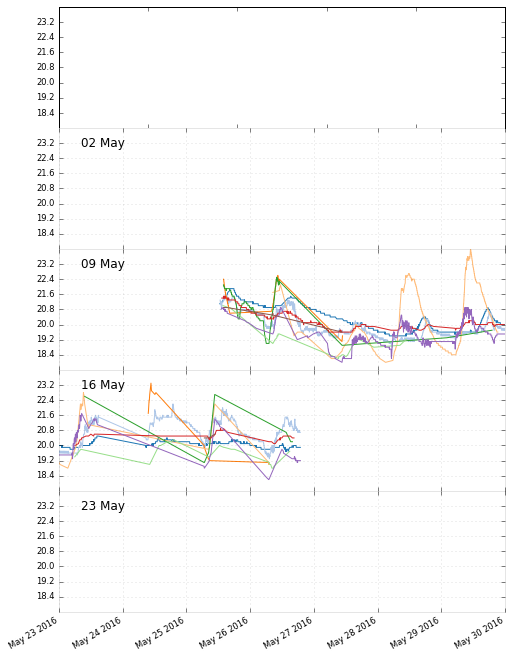

In [56]:
plt.show()